<h1>Pre-Processing</h1>

In [7]:
import glob
import librosa
import numpy as np
import tensorflow as tf
import torch
import torchvision.transforms as transforms
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

DATASET_PATH = 'D:/emotion_aware_speaker_identification/dataset/Ravedess dataset' 
PROCESSED_DATA_PATH = 'D:/emotion_aware_speaker_identification/code/processed_data'
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

TARGET_SIZE = (224, 224)
TARGET_SR = 22050
MAX_AUDIO_DURATION_SEC = 3

In [8]:
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [9]:
def extract_labels_from_path(filepath):
    try:
        
        filename = os.path.basename(filepath)
        parts = filename.split('-')
        
        if parts[0] != '03' or parts[1] != '01':
            return None, None
            
        emotion_code = parts[2]
        emotion_label = EMOTION_MAP.get(emotion_code)
        
        actor_id_str = parts[6]
        speaker_id = int(actor_id_str.split('.')[0])
        
        return speaker_id, emotion_label

    except Exception as e:
        print(f"Error extracting labels from {filepath}: {e}")
        return None, None


In [10]:
def get_preprocessed_data(dataset_path, target_size, target_sr, max_audio_duration_sec):
    """
    Finds all WAV files recursively, preprocesses them into log-mel spectrograms,
    and returns the data and labels.
    """
    audio_paths = glob.glob(os.path.join(dataset_path, '**/*.wav'), recursive=True)

    X_data = []
    y_speaker = []
    y_emotion = []

    all_spectrograms = []
    
    for filepath in audio_paths:
        speaker_id, emotion_label = extract_labels_from_path(filepath)

        if speaker_id is None or emotion_label is None:
            continue

        try:
            # Load and trim audio
            y, sr = librosa.load(filepath, sr = target_sr)
            y_trimmed, _ = librosa.effects.trim(y, top_db=20)

            max_audio_len = max_audio_duration_sec * target_sr
            if len(y_trimmed) > max_audio_len:
                y_final = y_trimmed[:max_audio_len]
            else:
                y_final = librosa.util.fix_length(y_trimmed, size=max_audio_len)

            # Generate log-mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y = y_final, sr = sr, n_mels = 128)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Resize and normalize
            log_mel_spectrogram_resized = tf.image.resize(
                np.expand_dims(log_mel_spectrogram, axis=-1),
                target_size,
                method='bilinear'
            )

            # log_mel_spectrogram_normalized = (log_mel_spectrogram_resized - tf.reduce_min(log_mel_spectrogram_resized)) / (tf.reduce_max(log_mel_spectrogram_resized) - tf.reduce_min(log_mel_spectrogram_resized))
            all_spectrograms.append(log_mel_spectrogram_resized.numpy()[:, :, 0])
            y_speaker.append(speaker_id)
            y_emotion.append(emotion_label)

        except Exception as e:
            print(f"Error processing {filepath}: {e}")
        
    if not all_spectrograms:
        print("No valid audio files found or processed.")
        return np.array([]), np.array([]), np.array([])

    all_spectrograms = np.array(all_spectrograms, dtype=np.float32)
        
    global_mean = np.mean(all_spectrograms)
    global_std = np.std(all_spectrograms)

    final_X_data = []

    for spectrogram in all_spectrograms:
        normalized_spectrogram = (spectrogram - global_mean) / (global_std + 1e-7)

        # Create the 3-channel tensor by tiling the single channel 3 times
        log_mel_spectrogram_3channel = np.stack(
            [normalized_spectrogram, normalized_spectrogram, normalized_spectrogram],
            axis=-1
        )
        final_X_data.append(log_mel_spectrogram_3channel)

    
    X_data = np.array(final_X_data)
    y_speaker = np.array(y_speaker)
    y_emotion = np.array(y_emotion)

    return X_data, y_speaker, y_emotion

In [11]:
if not os.path.exists(PROCESSED_DATA_PATH):
    os.makedirs(PROCESSED_DATA_PATH)

print("Starting preprocessing...")
X, y_speaker, y_emotion = get_preprocessed_data(DATASET_PATH, TARGET_SIZE, TARGET_SR, MAX_AUDIO_DURATION_SEC)
print("Preprocessing complete.")


np.save(os.path.join(PROCESSED_DATA_PATH, 'X_data.npy'), X)
np.save(os.path.join(PROCESSED_DATA_PATH, 'y_speaker.npy'), y_speaker)
np.save(os.path.join(PROCESSED_DATA_PATH, 'y_emotion.npy'), y_emotion)

print(f"Preprocessed data shape: {X.shape}")
print(f"Speaker labels shape: {y_speaker.shape}")
print(f"Emotion labels shape: {y_emotion.shape}")
print(f"Data saved to {PROCESSED_DATA_PATH}")

Starting preprocessing...
Preprocessing complete.
Preprocessed data shape: (1440, 224, 224, 3)
Speaker labels shape: (1440,)
Emotion labels shape: (1440,)
Data saved to D:/emotion_aware_speaker_identification/code/processed_data


Sample spectrogram shape: (224, 224, 3)


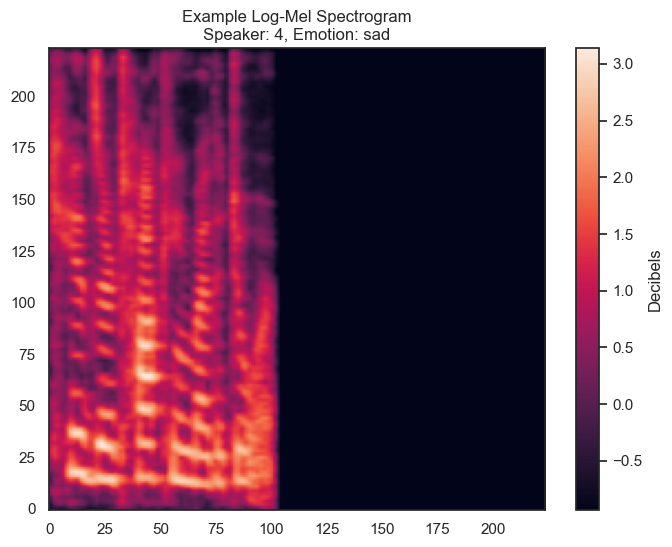

In [16]:
if X.size > 0:
    sample_spectrogram = X[200]
    print(f"Sample spectrogram shape: {sample_spectrogram.shape}")


    plt.figure(figsize=(8, 6))
    plt.imshow(sample_spectrogram[:, :, 0], aspect='auto', origin='lower')
    plt.title(f"Example Log-Mel Spectrogram\nSpeaker: {y_speaker[200]}, Emotion: {y_emotion[200]}")
    plt.colorbar(label='Decibels')
    plt.show()
else:
    print("No data was processed. Please check your dataset path and file names.")


